<a href="https://colab.research.google.com/github/ranamahmoud12/Angular-Project/blob/main/melanoma_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Melanoma binary classification using Transfer Learning CNN**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob as gb
import cv2
from keras.callbacks import EarlyStopping
from tqdm import tqdm
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.utils import shuffle
from tensorflow.keras import models
from tensorflow.keras import layers
import kerastuner as kt
import tensorflow as tf
import shutil
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications import Xception,MobileNetV2
from efficientnet import keras as efn

# **install efficientnet library**

In [ ]:
#  pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 982.6 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


# **Delete  trial Folders**

In [ ]:
folder_path = "/kaggle/working/vgg19_kt"
shutil.rmtree(folder_path, ignore_errors=True)

folder_path = "/kaggle/working/xception_kt"
shutil.rmtree(folder_path, ignore_errors=True)

folder_path = "/kaggle/working/effiecientnet_kt"
shutil.rmtree(folder_path, ignore_errors=True)

#  **Define Paths**

In [ ]:
train_path = '/kaggle/input/melanoma/DermMel/train_sep'

val_path='/kaggle/input/melanoma/DermMel/valid'

test_path = '/kaggle/input/melanoma/DermMel/test'

# **Check paths is correct**

In [ ]:
if os.path.exists(train_path):
   print(f"Train data is located at {train_path}")
else:
   print(f"Train data is not located at {train_path}")

if os.path.exists(val_path):
   print(f"Train data is located at {val_path}")
else:
   print(f"Train data is not located at {val_path}")

if os.path.exists(test_path):
   print(f"Test data is located at {test_path}")
else:
   print(f"Test data is not located at {test_path}")


Train data is located at /kaggle/input/melanoma/DermMel/train_sep
Train data is located at /kaggle/input/melanoma/DermMel/valid
Test data is located at /kaggle/input/melanoma/DermMel/test


# **Show the folders & length of folders in train set**

In [ ]:
for folder in os.listdir(train_path):
    # Use the glob pattern to search for both jpg and jpeg files
    files = gb.glob(pathname=str(train_path + '//' + folder + '/*.jpg')) + gb.glob(pathname=str(train_path + '//' + folder + '/*.jpeg'))
    print(f'For training data, found {len(files)} in folder {folder}')

For training data, found 5341 in folder Melanoma

For training data, found 5341 in folder NotMelanoma


# **Show the folders & length of folders in validation set**

In [ ]:
for folder in os.listdir(val_path):
    # Use the glob pattern to search for both jpg and jpeg files
    files = gb.glob(pathname=str(val_path + '//' + folder + '/*.jpg')) + gb.glob(pathname=str(val_path + '//' + folder + '/*.jpeg'))
    print(f'For validation data, found {len(files)} in folder {folder}')

For validation data, found 1781 in folder Melanoma

For validation data, found 1781 in folder NotMelanoma


# **Show the folders & length of folders in test set**

In [ ]:
for folder in os.listdir(test_path):
    # Use the glob pattern to search for both jpg and jpeg files
    files = gb.glob(pathname=str(test_path + '//' + folder + '/*.jpg')) + gb.glob(pathname=str(test_path + '//' + folder + '/*.jpeg'))
    print(f'For test data, found {len(files)} in folder {folder}')

For test data, found 1781 in folder Melanoma

For test data, found 1780 in folder NotMelanoma


# **Check the size of  in Train set images**

In [ ]:
img_size = []
for folder in os.listdir(train_path):
    files = gb.glob(pathname=str(train_path + '//' + folder + '/*.jpg')) + gb.glob(pathname=str(train_path + '//' + folder + '/*.jpeg'))

    for file in files:
        image = plt.imread(file) #For each JPG file, it loads the image using the plt.imread() function.
        img_size.append(image.shape)

pd.Series(img_size).value_counts() #It uses the value_counts() method to count the number of times each image size appears in the size Series.

(450, 600, 3)    6002
(224, 224, 3)    4680
Name: count, dtype: int64

# **Check the size of  in validation set images**

In [ ]:
img_size = []
for folder in os.listdir(val_path):
    files = gb.glob(pathname=str(val_path + '//' + folder + '/*.jpg')) + gb.glob(pathname=str(val_path + '//' + folder + '/*.jpeg'))

    for file in files:
        image = plt.imread(file) #For each JPG file, it loads the image using the plt.imread() function.
        img_size.append(image.shape)

pd.Series(img_size).value_counts() #It uses the value_counts() method to count the number of times each image size appears in the size Series.

(450, 600, 3)    1994
(224, 224, 3)    1568
Name: count, dtype: int64

# **Check the size of  in Test set images**

In [ ]:
img_size = []
for folder in os.listdir(test_path):
    files = gb.glob(pathname=str(test_path + '//' + folder + '/*.jpg')) + gb.glob(pathname=str(test_path + '//' + folder + '/*.jpeg'))

    for file in files:
        image = plt.imread(file) #For each JPG file, it loads the image using the plt.imread() function.
        img_size.append(image.shape)

pd.Series(img_size).value_counts() #It uses the value_counts() method to count the number of times each image size appears in the size Series.

(450, 600, 3)    2019
(224, 224, 3)    1542
Name: count, dtype: int64

# **Funtion to make Label for the Melanoma and not Melanoma Class**

In [ ]:
#convert from text to numeric
code = {'Melanoma':0 ,'NotMelanoma':1} #dictionary

#convert from numeric to  text
def getcode(n) :
    for x , y in code.items() :
        if n == y :
            return x

# **Determine image size**

In [ ]:
image_size=192

# **Divide Train set int X_train , y_train**

In [ ]:
X_train = []
y_train= []

for folder in os.listdir(train_path):
    files = gb.glob(pathname=str(train_path + '//' + folder + '/*.jpg')) + gb.glob(pathname=str(train_path + '//' + folder + '/*.jpeg'))
    for file in tqdm(files):
        image = cv2.imread(file)
        image_array = cv2.resize(image, (image_size, image_size))
        X_train.append(list(image_array))
        y_train.append(code[folder])

100%|██████████| 5341/5341 [01:45<00:00, 50.58it/s]


# **Show random sample from Train set**

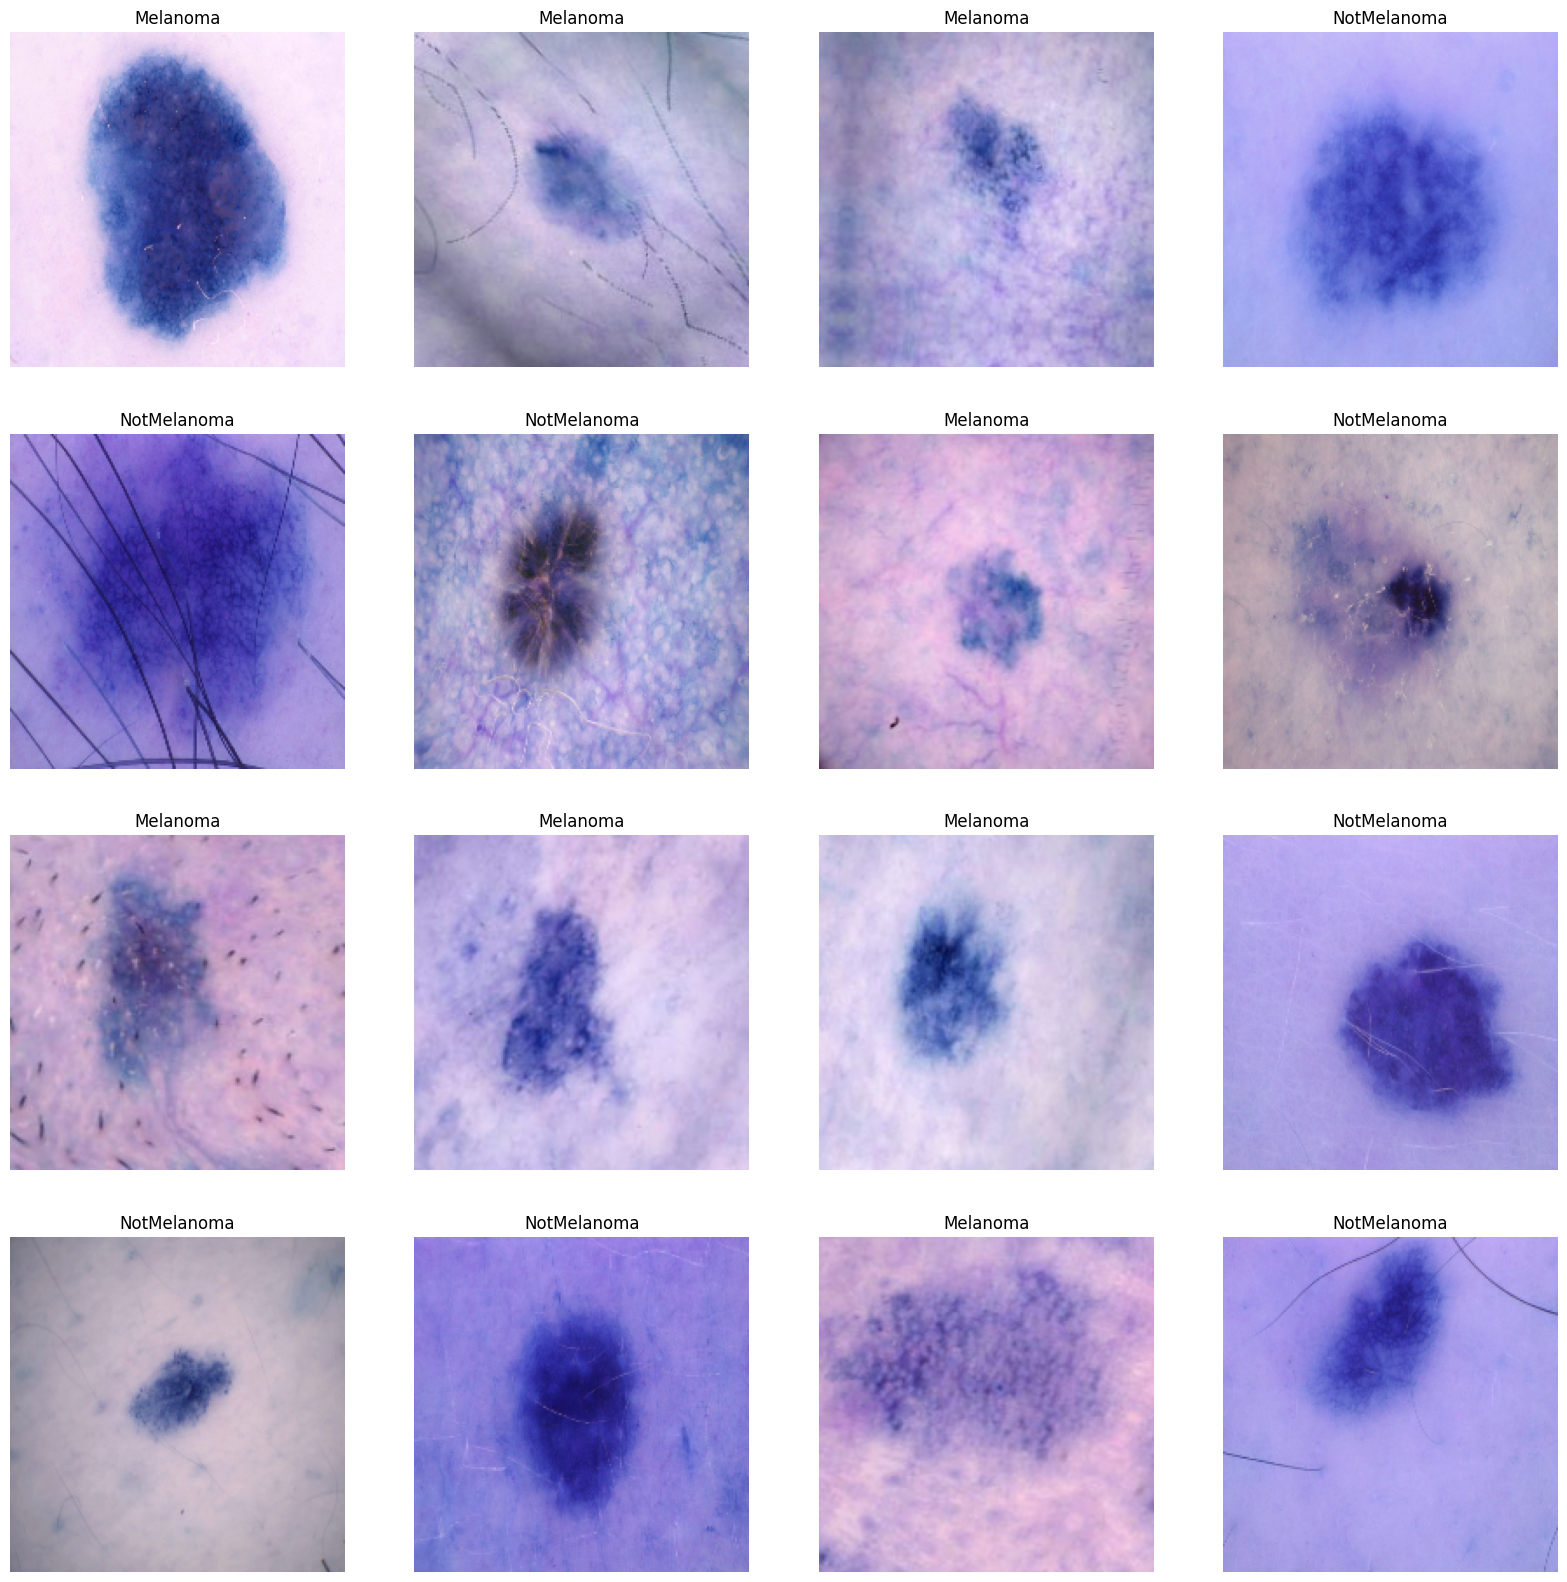

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_train),16))) :   #choose (16) random number from 0 t0 14034 #n-->index  , i-->value
    plt.subplot(4,4,n+1) # 4*4 =16 pictures
    plt.imshow(X_train[i])   #image show , picture is copressed by cv
    plt.axis('off')
    plt.title(getcode(y_train[i]))

# **Divide Validation set int X_val , y_val**

In [ ]:
X_val = []
y_val = []

for folder in  os.listdir(val_path) :
    files = gb.glob(pathname=str(val_path + '//' + folder + '/*.jpg')) + gb.glob(pathname=str(val_path + '//' + folder + '/*.jpeg'))
    for file in tqdm(files):
        image = cv2.imread(file)
        image_array = cv2.resize(image , (image_size,image_size))
        X_val.append(list(image_array))
        y_val.append(code[folder])

100%|██████████| 1781/1781 [00:34<00:00, 51.51it/s]


# **Show random sample from validation set**

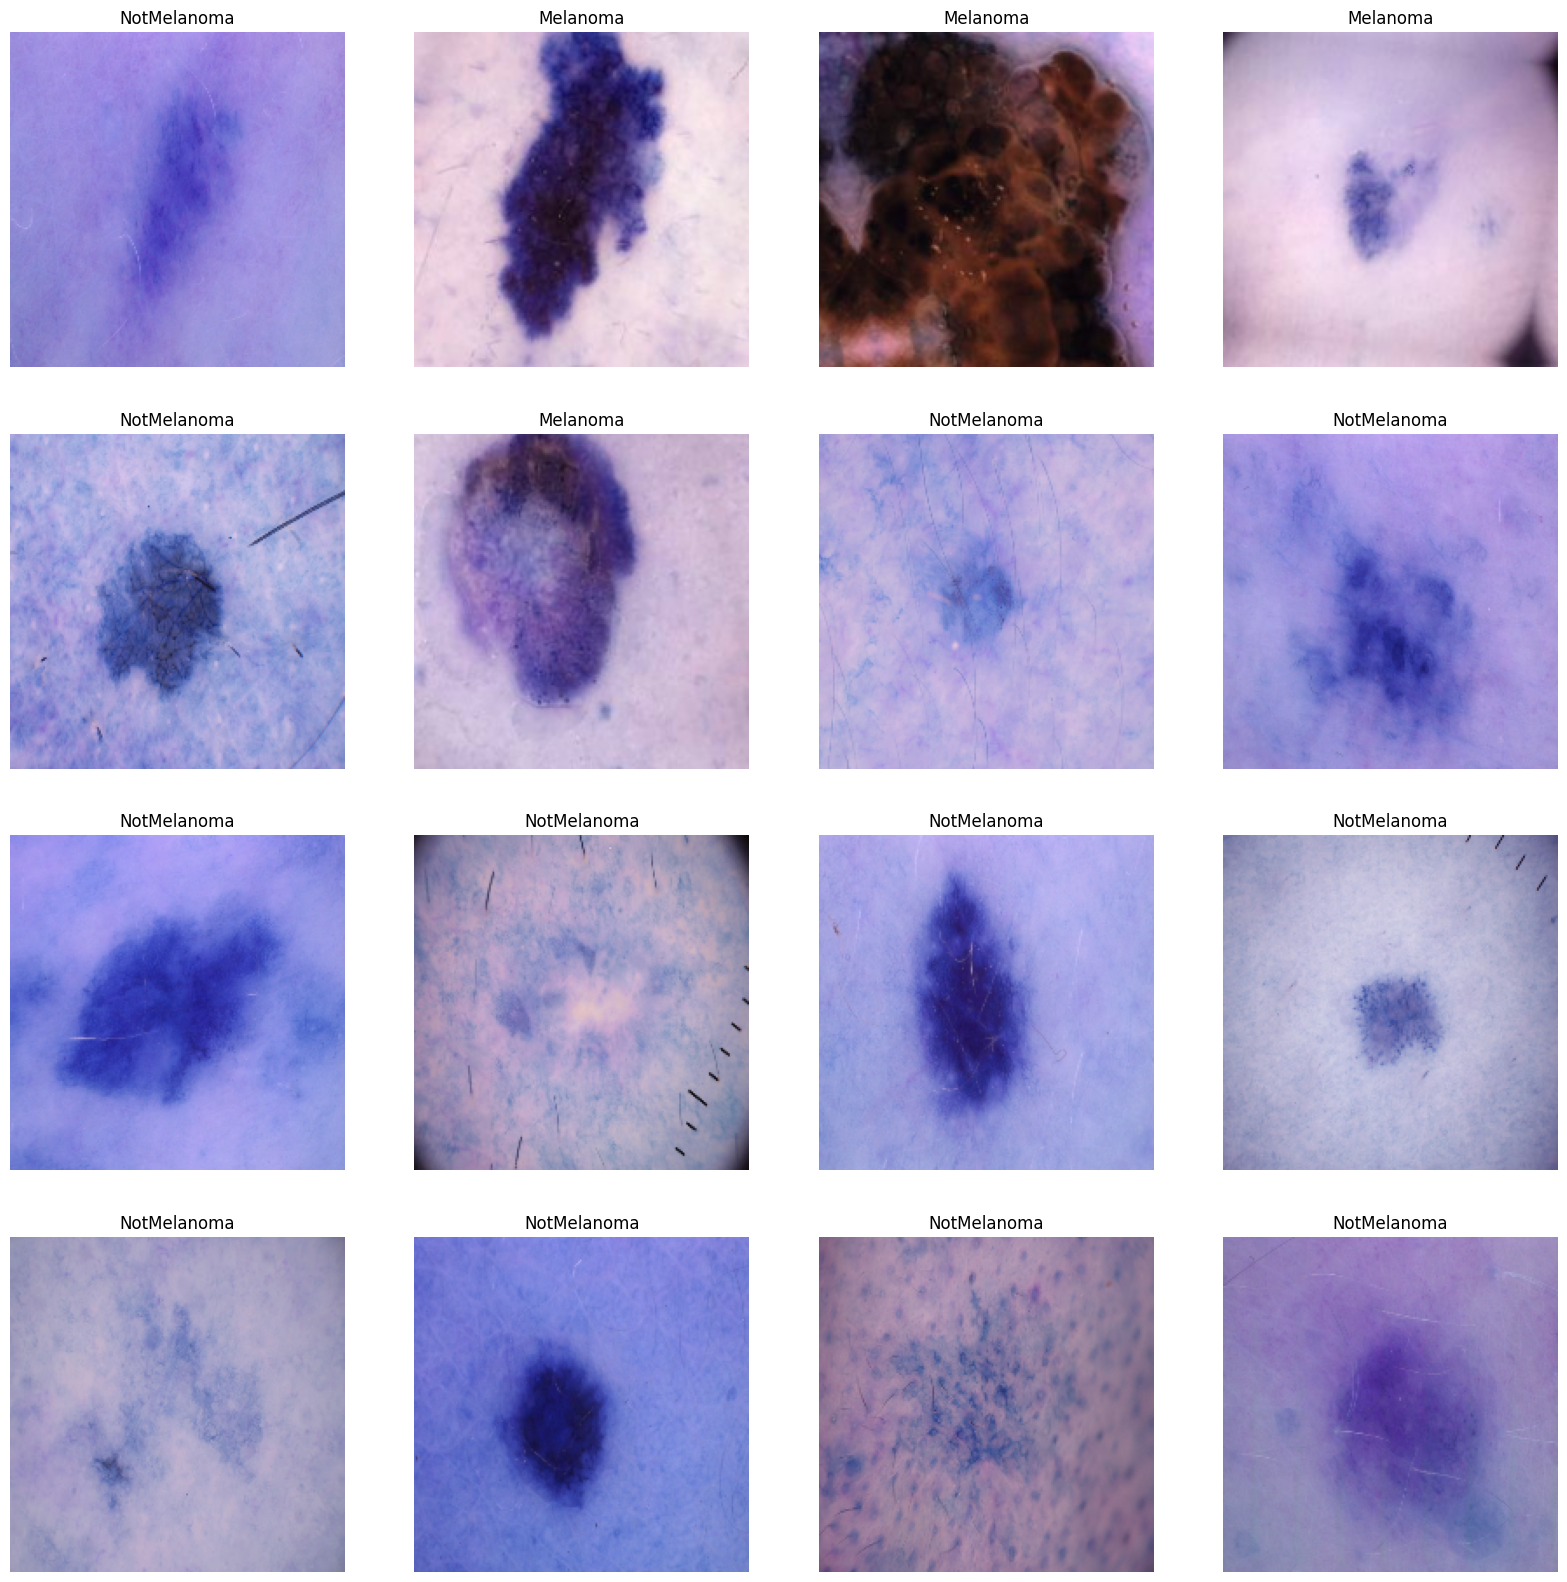

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_val),16))) :   #choose (16) random number from 0 t0 14034 #n-->index  , i-->value
    plt.subplot(4,4,n+1) # 4*4 =16 pictures
    plt.imshow(X_val[i])   #image show , picture is copressed by cv
    plt.axis('off')
    plt.title(getcode(y_val[i]))

# **Divide test set int X_test , y_test**

In [ ]:
X_test = []
y_test = []

for folder in  os.listdir(test_path) :
    files = gb.glob(pathname=str(test_path + '//' + folder + '/*.jpg')) + gb.glob(pathname=str(test_path + '//' + folder + '/*.jpeg'))
    for file in tqdm(files):
        image = cv2.imread(file)
        image_array = cv2.resize(image , (image_size,image_size))
        X_test.append(list(image_array))
        y_test.append(code[folder])

100%|██████████| 1780/1780 [00:34<00:00, 51.22it/s]


# **Show random sample from test set**

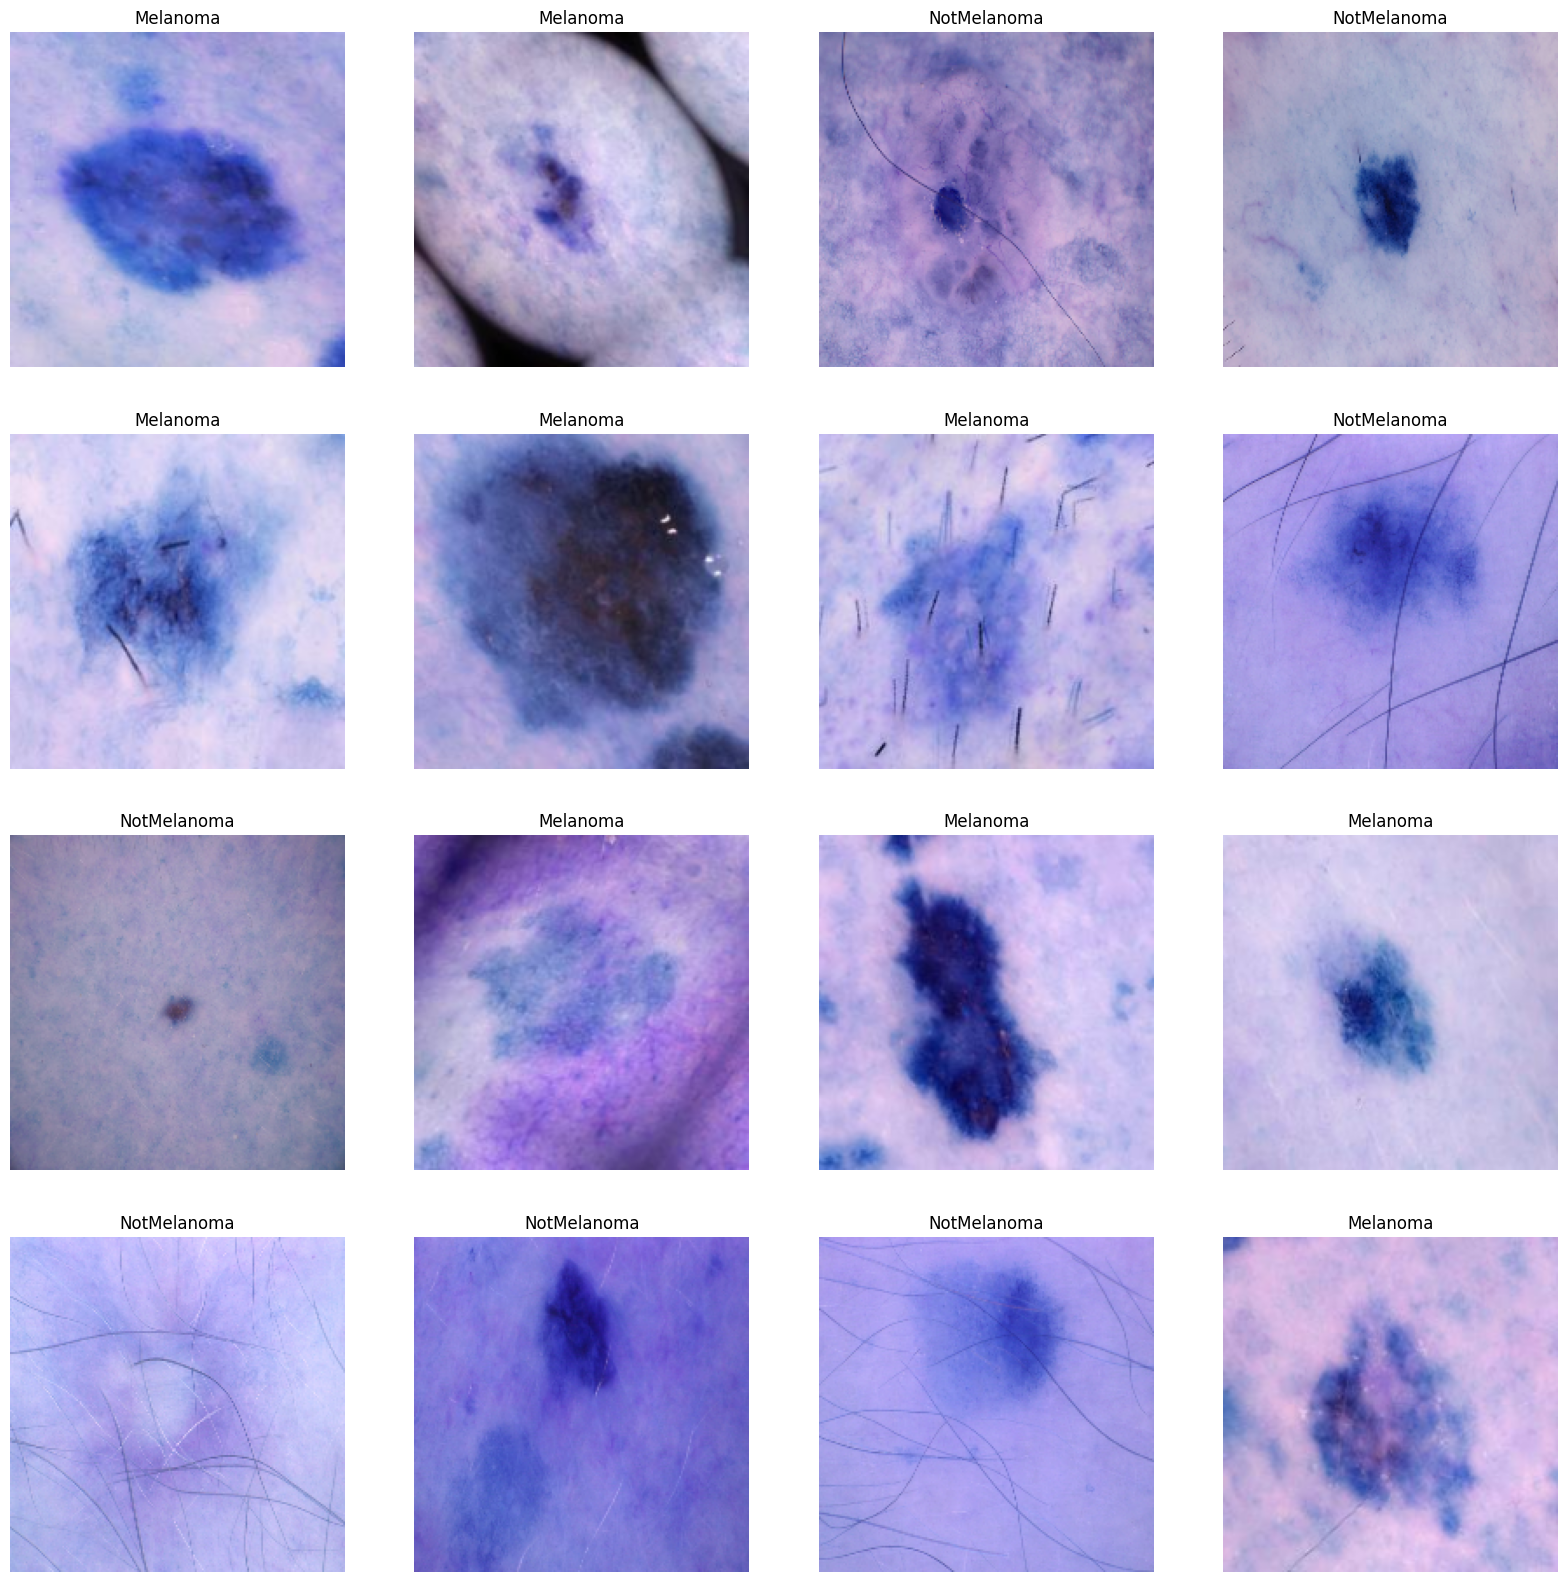

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_test),16))) :   #choose (16) random number from 0 t0 14034 #n-->index  , i-->value
    plt.subplot(4,4,n+1)  # 4*4 =16 pictures
    plt.imshow(X_test[i])     #image show , picture is copressed by cv
    plt.axis('off')
    plt.title(getcode(y_test[i]))

# **Convert X_train ,y_train , X_val ,y_val, X_test, y_test to Numpy Array**

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

# **Print the shapes of X_train ,y_train , X_val ,y_val, X_test, y_test**

In [ ]:
print("Train dataset shape:\n")
print(f'X_train shape  is {X_train.shape}\n')
print(f'y_train shape  is {y_train.shape}\n')

print("validation dataset shape:\n")
print(f'X_val shape  is {X_val.shape}\n')
print(f'y_val shape  is {y_val.shape}\n')

print("Test dataset shape:\n")
print(f'X_test shape  is {X_test.shape}\n')
print(f'y_test shape  is {y_test.shape}\n')

Train dataset shape:

X_train shape  is (10682, 192, 192, 3)

y_train shape  is (10682,)

validation dataset shape:

X_val shape  is (3562, 192, 192, 3)

y_val shape  is (3562,)

Test dataset shape:

X_test shape  is (3561, 192, 192, 3)

y_test shape  is (3561,)



# **Nomrmalization**

In [ ]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# **Data Augmentation Funtion to repeat augmentation number of times**

In [ ]:
# repetition=2
# def augment(dataset):
#    augmented_images = []
#    for image in dataset:
#        image = np.expand_dims(image, axis=0)
#        for _ in range(repetition):
#            random_seed = np.random.randint(0, 1000)
#            rotation_range = np.random.uniform(0, 20) # Randomly rotated by up to 20 degrees in either direction.
#            width_shift_range = np.random.uniform(0, 0.2) # Randomly shift images horizontally (fraction of total width)
#            height_shift_range = np.random.uniform(0, 0.2) # Randomly shift images vertically (fraction of total height)
#            shear_range = np.random.uniform(0, 0.2) # Set range for random shear
#            zoom_range = np.random.uniform(0, 0.2) # Set range for random zoom
#            data_augmentation = ImageDataGenerator(
#                rotation_range=rotation_range,
#                width_shift_range=width_shift_range,
#                height_shift_range=height_shift_range,
#                shear_range=shear_range,
#                zoom_range=zoom_range,
#                horizontal_flip=True, # Randomly flip images
#                fill_mode='nearest' # Set mode for filling points outside the input boundaries
#            )
#            for batch in data_augmentation.flow(image, batch_size=1, seed=random_seed):
#                augmented_images.append(np.squeeze(batch))
#                break
#    return np.array(augmented_images)


# X_train_augmented = augment(X_train)
# y_train_augmented = np.repeat(y_train, repetition, axis=0)

# X_test_augmented = augment(X_test)
# y_test_augmented = np.repeat(y_test, repetition, axis=0)


# **Combine original & augmented data & shuffle them**

In [ ]:
# # Merge original and augmented data
# X_train_merged = np.append(X_train, X_train_augmented, axis=0)
# y_train_merged = np.append(y_train, y_train_augmented, axis=0)

# X_train_merged, y_train_merged = shuffle(X_train_merged, y_train_merged, random_state=42)

# X_test_merged = np.append(X_test, X_test_augmented, axis=0)
# y_test_merged = np.append(y_test, y_test_augmented, axis=0)

# X_test_merged, y_test_merged = shuffle(X_test_merged, y_test_merged, random_state=42)


# **print the augmented data shape**

In [ ]:
# print("Train dataset shape:\n")
# print(f'X_train shape  is {X_train_merged.shape}\n')
# print(f'y_train shape  is {y_train_merged.shape}\n')

# print("Test dataset shape:\n")
# print(f'X_test shape  is {X_test_merged.shape}\n')
# print(f'y_test shape  is {y_test_merged.shape}\n')


# **rearrange the order of the sets**

In [ ]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# **Xception Model**

In [ ]:
def build_model(hp):
    google_base = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Freeze all layers except the last 4 convolutional blocks
    for layer in google_base.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(google_base)
    model.add(layers.Flatten())

    # Tune FC layer units and dropout rate
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))

    #output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
           optimizer = 'adam',
           loss='binary_crossentropy',
           metrics=['accuracy']
       )

    return model

# **Keras Tuner for xception model**

In [ ]:
objective = kt.Objective(
       name="val_accuracy",
       direction="max")

tuner = kt.GridSearch(
       build_model,
       objective=objective,
       max_trials = 4,
       executions_per_trial=5,
       directory="xception_kt",
       overwrite=True,
    )

tuner.search_space_summary()

# **Effiecientnet Model**

In [ ]:
def build_model(hp):
    effiecientnet = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Freeze all layers except the last 4 convolutional blocks
    for layer in effiecientnet.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(effiecientnet)
    model.add(layers.Flatten())

    # Tune FC layer units and dropout rate
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))

    #output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
           optimizer = 'adam',
           loss='binary_crossentropy',
           metrics=['accuracy']
       )

    return model

# **Keras Tuner for effiecientnet model**

In [ ]:
objective = kt.Objective(
       name="val_accuracy",
       direction="max")

tuner = kt.GridSearch(
       build_model,
       objective=objective,
       max_trials = 4 ,
       executions_per_trial=5,
       directory="effiecientnet_kt",
       overwrite=True,
    )

tuner.search_space_summary()

# **MobileNetV2 Model**

In [ ]:
def build_model(hp):
    mobilenet =MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Freeze all layers except the last 4 convolutional blocks
    for layer in mobilenet.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(mobilenet)
    model.add(layers.Flatten())

    # Tune FC layer units and dropout rate
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))

    #output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
           optimizer = 'adam',
           loss='binary_crossentropy',
           metrics=['accuracy']
       )

    return model

# **Keras Tuner for mobilenet model**

In [ ]:
objective = kt.Objective(
       name="val_accuracy",
       direction="max")

tuner = kt.GridSearch(
       build_model,
       objective=objective,
       max_trials = 3,
       executions_per_trial=5,
       directory="mobilenet_kt",
       overwrite=True,
    )

tuner.search_space_summary()

9406464/9406464 [==============================] - 0s 0us/step
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}


# **The hyperparameter search for all model**

* Note : run this cell after one model only at each run time

In [ ]:
tuner.search(X_train, y_train, epochs= 7, validation_data=(X_val, y_val))

Trial 3 Complete [00h 11m 05s]
val_accuracy: 0.9384053945541382

Best val_accuracy So Far: 0.9393599033355713
Total elapsed time: 00h 33m 31s


# **Find the best hyperparameters for a model**

* Note : run this cell after one model only at each run time

In [ ]:
best_model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])

# **ModelSummary**
* Note : run this cell after one model only at each run time

In [ ]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 46080)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                2949184   
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

# **Train the  Xception Model**

In [ ]:
callbacks = [

    tf.keras.callbacks.ModelCheckpoint('xception_model.h5', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3
      )
    ]

 history = best_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks)

# **Train the  Effiecientnet Model**

In [ ]:

callbacks = [
       tf.keras.callbacks.ModelCheckpoint('effiecientnet_model.h5', save_best_only=True),
       tf.keras.callbacks.EarlyStopping(
           monitor='val_loss', patience=3
       )
    ]

history = best_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks)

# **Train the  Mobilenet Model**

In [ ]:
callbacks = [
       tf.keras.callbacks.ModelCheckpoint('mobilenet_model.h5', save_best_only=True),
       tf.keras.callbacks.EarlyStopping(
           monitor='val_loss', patience=3
       )
    ]

history = best_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
333/334 [============================>.] - ETA: 0s - loss: 0.3620 - accuracy: 0.8586

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


334/334 [==============================] - 24s 59ms/step - loss: 0.3618 - accuracy: 0.8587 - val_loss: 0.1880 - val_accuracy: 0.9351
Epoch 2/50
334/334 [==============================] - 15s 45ms/step - loss: 0.2690 - accuracy: 0.8871 - val_loss: 0.1933 - val_accuracy: 0.9360
Epoch 3/50
334/334 [==============================] - 15s 46ms/step - loss: 0.2491 - accuracy: 0.8975 - val_loss: 0.1680 - val_accuracy: 0.9380
Epoch 4/50
334/334 [==============================] - 15s 46ms/step - loss: 0.2259 - accuracy: 0.8991 - val_loss: 0.1665 - val_accuracy: 0.9380
Epoch 5/50
334/334 [==============================] - 15s 45ms/step - loss: 0.2157 - accuracy: 0.9018 - val_loss: 0.1614 - val_accuracy: 0.9371
Epoch 6/50
334/334 [==============================] - 15s 45ms/step - loss: 0.2110 - accuracy: 0.8999 - val_loss: 0.1636 - val_accuracy: 0.9394
Epoch 7/50
334/334 [==============================] - 15s 44ms/step - loss: 0.1983 - accuracy: 0.8978 - val_loss: 0.1657 - val_accuracy: 0.9396
Epo

# **Delete  trial Folder**

In [ ]:
folder_path = "/kaggle/working/effficientnet_kt"
shutil.rmtree(folder_path, ignore_errors=True)

folder_path = "/kaggle/working/xception_kt"
shutil.rmtree(folder_path, ignore_errors=True)

folder_path = "/kaggle/working/mobilenet_kt"
shutil.rmtree(folder_path, ignore_errors=True)

# **Plot the training and validation accuracy and loss**

* Note : run this cell after one model only at each run time

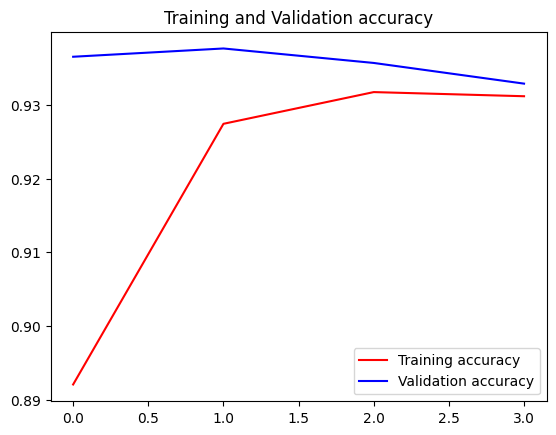

<Figure size 640x480 with 0 Axes>

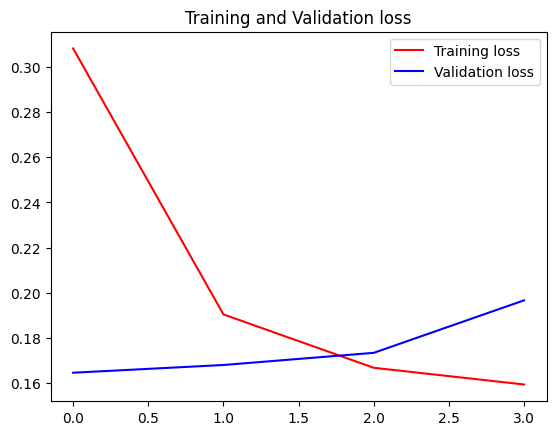

<Figure size 640x480 with 0 Axes>

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(len(training_accuracy))

plt.plot(epochs, training_accuracy, 'r', label="Training accuracy")
plt.plot(epochs, validation_accuracy, 'b', label="Validation accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# Plot the training and validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(epochs, training_loss, 'r', label="Training loss")
plt.plot(epochs, validation_loss, 'b', label="Validation loss")
plt.title('Training and Validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

# **Evaluate the Model**

* Note : run this cell after one model only at each run time

In [ ]:
result = best_model.evaluate(X_test, y_test)
Test_Loss = result[0]
Test_Accuracy = result[1]
# Test_Loss , Test_Accuracy = best_model.evaluate(X_test, y_test)
# If the result is a list containing test loss and test accuracy


print('Test Loss is {}'.format(Test_Loss))
print('Test Accuracy is {}'.format(Test_Accuracy))

112/112 [==============================] - 3s 27ms/step - loss: 0.2026 - accuracy: 0.9267 - auc_1: 0.9747

Test Loss is 0.20258741080760956

Test Accuracy is 0.9267059564590454


# **Upgrade tensorflow library**

In [ ]:
# pip install --upgrade tensorflow

# **Xception Model prediction & evaluation**

In [ ]:
xception_model = load_model('/kaggle/input/xception-model-h5/xception_model.h5', compile=False)

y_pred_xception = xception_model.predict(X_test)
y_pred_xception   = (y_pred_xception > 0.5).astype(int)


accuracy_xception = accuracy_score(y_test, y_pred_xception)
precision_xception = precision_score(y_test, y_pred_xception)
recall_xception = recall_score(y_test, y_pred_xception)
f1score_xception = f1_score(y_test, y_pred_xception)

print('Xception result:')
print("Accuracy:", accuracy_xception)
print("Precision:", precision_xception)
print("Recall:", recall_xception)
print("F1 Score:", f1score_xception)

112/112 [==============================] - 11s 90ms/step

Xception result:

Accuracy: 0.9140690817186183

Precision: 0.8830561330561331

Recall: 0.9544943820224719

F1 Score: 0.9173866090712743


# **Classification reprot for Xception Model**

In [ ]:
report = classification_report(y_test, y_pred_xception)
print(report)

              precision    recall  f1-score   support



           0       0.95      0.87      0.91      1781

           1       0.88      0.95      0.92      1780



    accuracy                           0.91      3561

   macro avg       0.92      0.91      0.91      3561

weighted avg       0.92      0.91      0.91      3561




# **Xception Model confusion matrix**

In [ ]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_xception)

# assign TP, FN, FP, TN
tn, fp, fn, tp = cm.ravel()

print("True Positives :", tp)
print("True Negatives :", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives : 1699

True Negatives : 1556

False Positives: 225

False Negatives: 81


# **Draw confusion matrix**

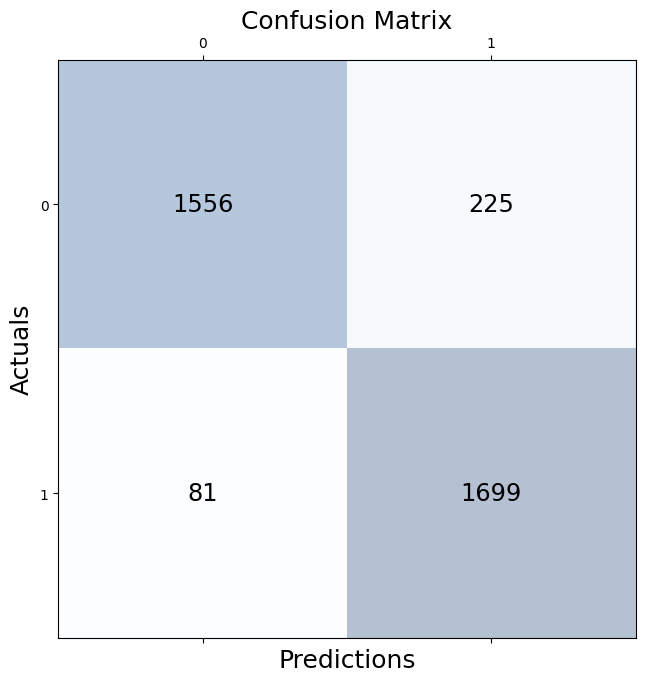

In [ ]:
# Plotting the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
   for j in range(cm.shape[1]):
       ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# **Effiecientnet Model prediction & evaluation**

In [ ]:
effiecientnet_model = load_model('/kaggle/input/effiecientnet-model-h5/effiecientnet_model.h5', compile=False)

y_pred_effiecientnet = effiecientnet_model.predict(X_test)
y_pred_effiecientnet   = (y_pred_effiecientnet > 0.5).astype(int)


accuracy_effiecientnet = accuracy_score(y_test, y_pred_effiecientnet)
precision_effiecientnet = precision_score(y_test, y_pred_effiecientnet)
recall_effiecientnet = recall_score(y_test, y_pred_effiecientnet)
f1score_effiecientnet = f1_score(y_test, y_pred_effiecientnet)

print('effiecientnet result:')
print("Accuracy:", accuracy_effiecientnet)
print("Precision:", precision_effiecientnet)
print("Recall:", recall_effiecientnet)
print("F1 Score:", f1score_effiecientnet)

112/112 [==============================] - 5s 35ms/step

effiecientnet result:

Accuracy: 0.9076102218477956

Precision: 0.8596926127912742

Recall: 0.9741573033707865

F1 Score: 0.913352646826442


# **Classification reprot for Effiecientnet Model**

In [ ]:
report = classification_report(y_test, y_pred_effiecientnet)
print(report)

              precision    recall  f1-score   support



           0       0.97      0.84      0.90      1781

           1       0.86      0.97      0.91      1780



    accuracy                           0.91      3561

   macro avg       0.91      0.91      0.91      3561

weighted avg       0.91      0.91      0.91      3561




# **Effiecientnet Model confusion matrix**

In [ ]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_effiecientnet)

# assign TP, FN, FP, TN
tn, fp, fn, tp = cm.ravel()

print("True Positives :", tp)
print("True Negatives :", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives : 1734

True Negatives : 1498

False Positives: 283

False Negatives: 46


# **Draw confusion matrix**

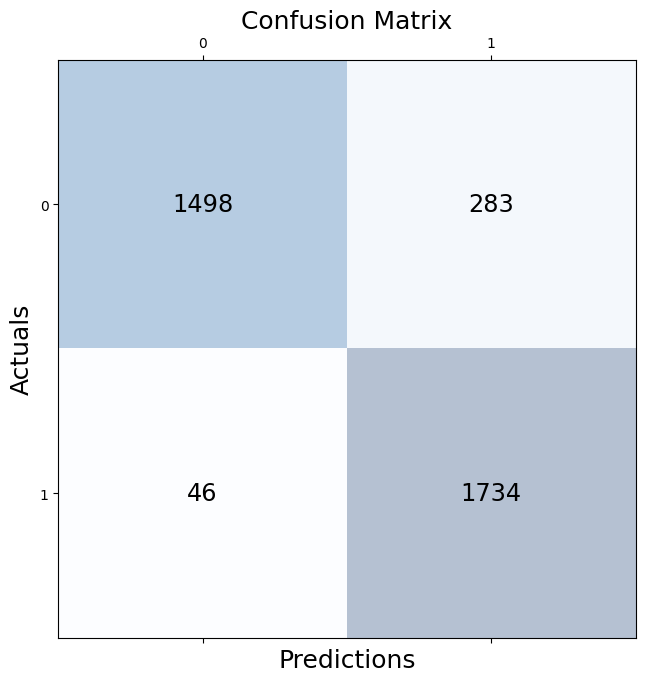

In [ ]:
# Plotting the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
   for j in range(cm.shape[1]):
       ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# **Mobilenet Model prediction & evaluation**

In [ ]:
mobilenet_model = load_model('/kaggle/input/mobilenet-model-h5/mobilenet_model.h5', compile=False)

y_pred_mobilenet= mobilenet_model.predict(X_test)
y_pred_mobilenet   = (y_pred_mobilenet > 0.5).astype(int)


accuracy_mobilenet = accuracy_score(y_test, y_pred_mobilenet)
precision_mobilenet = precision_score(y_test, y_pred_mobilenet)
recall_mobilenet = recall_score(y_test, y_pred_mobilenet)
f1score_mobilenet = f1_score(y_test, y_pred_mobilenet)

print('mobilenet result:')
print("Accuracy:", accuracy_mobilenet)
print("Precision:", precision_mobilenet)
print("Recall:", recall_mobilenet)
print("F1 Score:\n", f1score_mobilenet)

112/112 [==============================] - 13s 24ms/step
mobilenet result:
Accuracy: 0.9331648413367032
Precision: 0.8828202581926514
Recall: 0.998876404494382
F1 Score:
 0.9372693726937268


# **Classification reprot for Mobilenet Model**

In [ ]:
report = classification_report(y_test, y_pred_mobilenet)
print(report)

              precision    recall  f1-score   support



           0       1.00      0.87      0.93      1781

           1       0.88      1.00      0.94      1780



    accuracy                           0.93      3561

   macro avg       0.94      0.93      0.93      3561

weighted avg       0.94      0.93      0.93      3561




# **Mobilenet Model confusion matrix**

In [ ]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_mobilenet)

# assign TP, FN, FP, TN
tn, fp, fn, tp = cm.ravel()

print("True Positives :", tp)
print("True Negatives :", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives : 1778

True Negatives : 1545

False Positives: 236

False Negatives: 2


# **Draw confusion matrix**

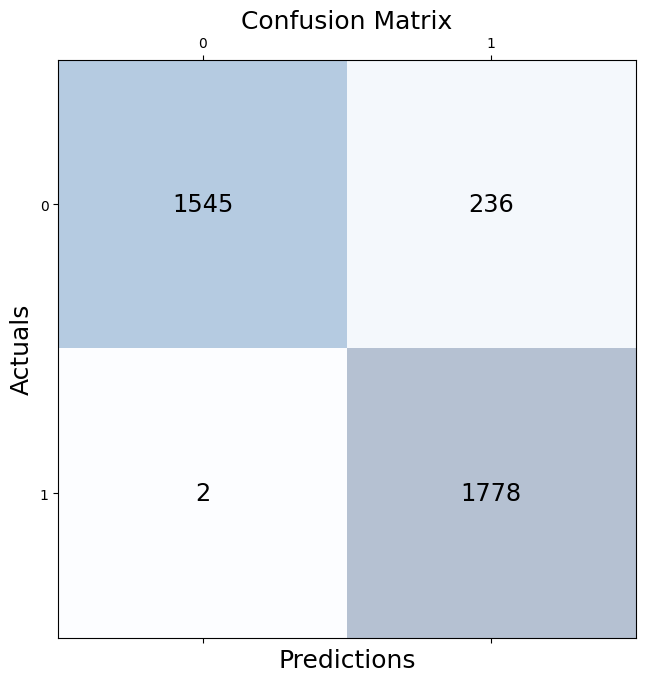

In [ ]:
# Plotting the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
   for j in range(cm.shape[1]):
       ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()